In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from transform import LinearTransform
from transform import MultiLayerPerceptron as MLP
from aevb import AutoEncodingVariationalBayes as vae
from aevb import FLDSVB
from dynamics import FLDS, KalmanFilter, MarkovDynamics, MLPDynamics, DeepKalmanFilter, DeepKalmanDynamics
from model import ReparameterizedDistribution
from distribution import MultiplicativeNormal
from vis.dynamic import TrajectoryPlot

from norm_flow import TimeAutoRegressivePlanarFlow
from norm_flow_model import NormalizingFlowModel
from distribution import StateSpaceNormalDiag

from vis.dynamic import Diagnostics
from vis.util import plot_elbo
from utils.synthetic import lorenz, euler_solve_forward
from utils.eval import k_step_extrapolation_error


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Generating Synthetic Data Set

$\mathbf{z_t}$s are generated from a Lorenz System with Gaussian noise.

- $y_t \sim \mathcal{N}(f_{NN}(z_t), \mathbf{I})$ for $t=1, \ldots, T$


Where $f_{NN}(z_t)$ is a single layer MLP with softplus $\log(1 + \exp(.))$ activations.


In [2]:
DIM = 3
LAT_DIM = 3
TIME = 40
LEAVE_OUT = 20
N_EXAMPLES = 100 # Total number of paths
ORDER = 1

x_init_ = np.random.normal(0, 2, [N_EXAMPLES, LAT_DIM])
noise_covar_ = np.eye(LAT_DIM) * .1
data = euler_solve_forward(
    x_init_, lorenz, TIME + LEAVE_OUT, noise_covar=noise_covar_, d_time=0.01)


# Non-linear transform of latent to observations
NOISE = np.random.normal(0, .2, data.shape)
DATA = data + np.log(1 + np.exp(data)) + NOISE

# Dividing the data into test and train set and extrapolations
cut_off_ = int(N_EXAMPLES * .9)
TRAIN_DATA = DATA[:cut_off_, :TIME]
TEST_DATA = DATA[cut_off_:, :TIME]

TRAIN_DATA_REST = DATA[:cut_off_, TIME:]
TEST_DATA_REST = DATA[cut_off_:, TIME:]

# Trajectory plots for latent and observation trajectories
tplot = TrajectoryPlot(TRAIN_DATA)
hidden_tplot = TrajectoryPlot(data)

# Visualizing Latent Paths

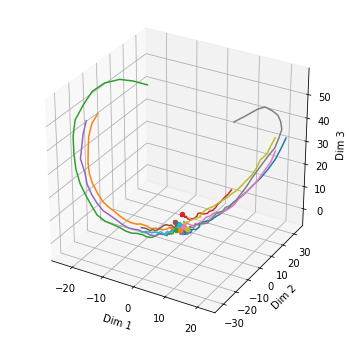

In [3]:
hidden_tplot.plot([0, 1, 2], PCA=False, data=data[-10:, :TIME, :])
plt.gcf().set_size_inches(6, 6)

# Visualizing Observation Paths

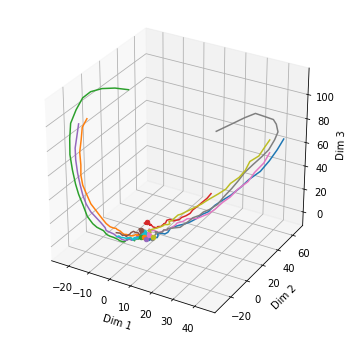

In [4]:
tplot.plot([0, 1, 2], PCA=False, data=TEST_DATA)
plt.gcf().set_size_inches(6, 6)

In [5]:
STEPS = 2000

BATCH_SIZE = 1
SAMPLE_SIZE = 10

TRANSITION_LAYERS = [20, 20]
EMISSION_LAYERS = [50, 50]

RECOGNITION_LAYERS = [50, 50]

# Setting Up the Normalizing Flow model

In the case of normalizing flow we are free to choose different generative models.

In the case below we are setting the $p(x, z)$ to be linear transition with MLP emmision with Gaussian noise. `MODEL_LAYERS` indicates the hidden units/layers of the MLP.

For the encoding Normalizing Flow model we choose another MLP to map observations to parameters of the flow.
`RECOGNITION_LAYERS` governs this MLP.

In [6]:
graph = tf.Graph()

with graph.as_default():
    
    gen_model = MLPDynamics(
        lat_dim=LAT_DIM, obs_dim=DIM, time_steps=TIME,
        transition_layers=TRANSITION_LAYERS, emission_transform=MLP,
        hidden_units=EMISSION_LAYERS)

    base_model = ReparameterizedDistribution(
        out_dim=(TIME, LAT_DIM), in_dim=(TIME, DIM),
        distribution=StateSpaceNormalDiag,
        transform=MLP,
        reparam_scale=True, hidden_units=RECOGNITION_LAYERS)

    recon_model = NormalizingFlowModel(
        in_dim=(TIME, DIM), base_model=base_model,
        norm_flow_type=TimeAutoRegressivePlanarFlow,
        norm_flow_params={"num_layer": 5},
        transform_type=MLP,
        transform_params={"hidden_units": RECOGNITION_LAYERS})

    v = vae(data=TRAIN_DATA, generative_model=gen_model,
            recognition_model=recon_model,
            n_monte_carlo_samples=SAMPLE_SIZE,
            batch_size=BATCH_SIZE,
            optimizer=tf.train.AdamOptimizer(learning_rate=0.001))

    # Losses
    l = v.train(steps=STEPS)
    # Get reconstruction and code for some training samples
    r = v.get_reconstructions(TEST_DATA)
    c = v.get_codes(TEST_DATA)

    diag = Diagnostics(dynamics=v.gen_model, session=v.sess, samples=data,
                       n_examples=10, time_forward=LEAVE_OUT, grid_size=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions`

100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


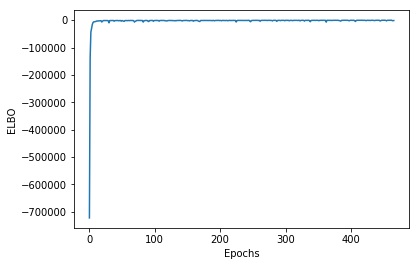

In [15]:
plot_elbo(l, skip=100, epoch=90, offset=0)


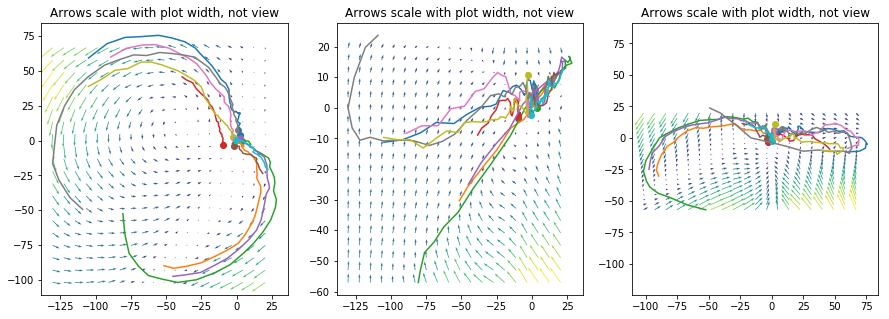

In [16]:
with graph.as_default():

    diag.update_samples(c.mean(axis=1))

    fig, ax = plt.subplots(1, 3)
    diag.get_grid_values(ax=ax[0], n_path=10)
    diag.get_grid_values(0, 2, ax=ax[1], n_path=10)
    diag.get_grid_values(1, 2, ax=ax[2], n_path=10)
    fig.set_size_inches(15, 5)

# Learn, learn, learn...!

In [12]:
with graph.as_default():
    l += v.train(steps=20*STEPS)
    r = v.get_reconstructions(TEST_DATA)
    c = v.get_codes(TEST_DATA)

100%|██████████| 10/10 [00:00<00:00, 138.73it/s]


# Deep Kalman Filter

In [10]:
graph3 = tf.Graph()

with graph3.as_default():
    
    #gen_model = MLPDynamics(
    #    lat_dim=LAT_DIM, obs_dim=DIM, time_steps=TIME,
    #    transition_layers=TRANSITION_LAYERS, emission_transform=MLP,
    #    hidden_units=EMISSION_LAYERS)

    gen_model = DeepKalmanDynamics(
        lat_dim=LAT_DIM, obs_dim=DIM, time_steps=TIME,
        transition_units=10, emission_layers=EMISSION_LAYERS)

    recon_model = DeepKalmanFilter(
        in_dim=DIM, out_dim=LAT_DIM, time_steps=TIME,
        rnn_hdim=10, mean_field=False, backward=True)

    v3 = vae(data=TRAIN_DATA, generative_model=gen_model,
            recognition_model=recon_model,
            n_monte_carlo_samples=SAMPLE_SIZE,
            batch_size=BATCH_SIZE,
            optimizer=tf.train.AdamOptimizer(learning_rate=0.001))

    # Losses
    l3 = v3.train(steps=STEPS)
    # Get reconstruction and code for some training samples
    r3 = v3.get_reconstructions(TEST_DATA)
    c3 = v3.get_codes(TEST_DATA)

    diag3 = Diagnostics(dynamics=v3.gen_model, session=v3.sess, samples=data,
                       n_examples=10, time_forward=LEAVE_OUT, grid_size=20)

100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


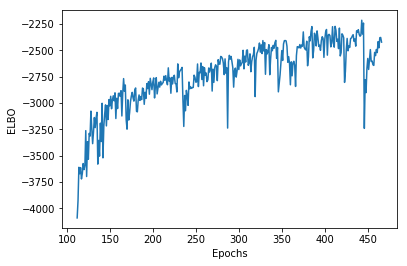

In [17]:
plot_elbo(l3, skip=90, epoch=90, offset=10000)

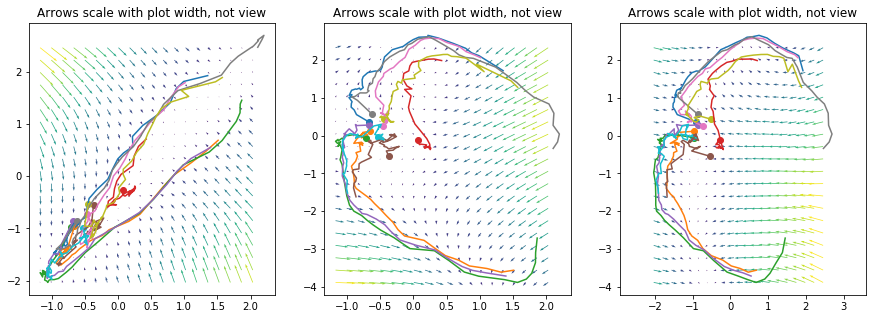

In [18]:
with graph3.as_default():

    diag3.update_samples(c3.mean(axis=1))

    fig, ax = plt.subplots(1, 3)
    diag3.get_grid_values(ax=ax[0], n_path=10)
    diag3.get_grid_values(0, 2, ax=ax[1], n_path=10)
    diag3.get_grid_values(1, 2, ax=ax[2], n_path=10)
    fig.set_size_inches(15, 5)

In [13]:
with graph3.as_default():
    l3 += v3.train(steps=20*STEPS)
    r3 = v3.get_reconstructions(TEST_DATA)
    c3 = v3.get_codes(TEST_DATA)

100%|██████████| 10/10 [00:00<00:00, 144.68it/s]


# FLDS

# Setting Up the fLDS model

parameters that the `FLDSVB` which is an extension of the `AutoEncodinVariationalBayes` is the following:

- `data` with shape (# examples, # time steps, # dimensions)
- `lat_dim`: dimensionality of the latent space
- `n_monte_carlo_samples`: Number of Monte Carlo samples for estimating gradients
- `batch_size`
- `optimizer` which is a tensor flow optimizer
- type of non-linear transformation and it's architecture parameters (In the library there are basic transforms (planning on adding more...)

In [11]:
graph2 = tf.Graph()

recon_idx = range(10)

with graph2.as_default():

    v2 = FLDSVB(data=TRAIN_DATA, lat_dim=LAT_DIM, nonlinear_transform=MLP,
               n_monte_carlo_samples=SAMPLE_SIZE, batch_size=BATCH_SIZE,
               optimizer=tf.train.AdamOptimizer(learning_rate=0.001), full_covariance=False,
               hidden_units=RECOGNITION_LAYERS)

    # Losses
    l2 = v2.train(steps=STEPS)
    # Get reconstruction and code for some training samples
    r2 = v2.get_reconstructions(TEST_DATA)
    c2 = v2.get_codes(TEST_DATA)

    diag2 = Diagnostics(dynamics=v2.gen_model, session=v2.sess, samples=data,
                        n_examples=10, time_forward=LEAVE_OUT, grid_size=20)

100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


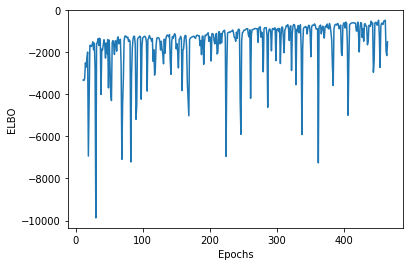

In [19]:
plot_elbo(l, skip=100, epoch=90, offset=1000)

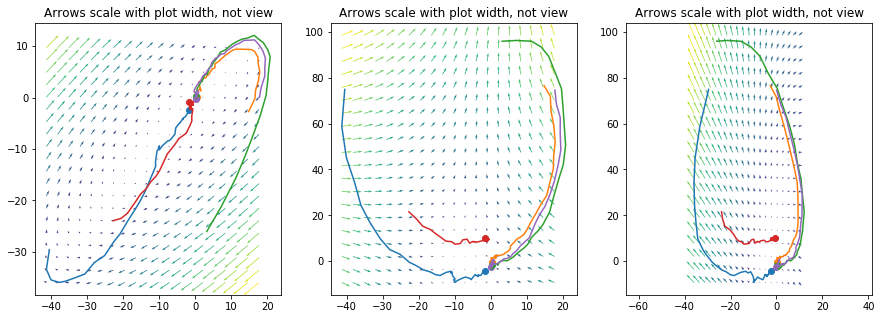

In [20]:
with graph2.as_default():
    diag2.update_samples(c2.mean(axis=1))

    fig, ax = plt.subplots(1, 3)
    diag2.get_grid_values(ax=ax[0])
    diag2.get_grid_values(0, 2, ax=ax[1])
    diag2.get_grid_values(1, 2, ax=ax[2])
    fig.set_size_inches(15, 5)

In [14]:
with graph2.as_default():
    l2 += v2.train(steps=20*STEPS)
    r2 = v2.get_reconstructions(TEST_DATA)
    c2 = v2.get_codes(TEST_DATA)

100%|██████████| 10/10 [00:00<00:00, 261.99it/s]


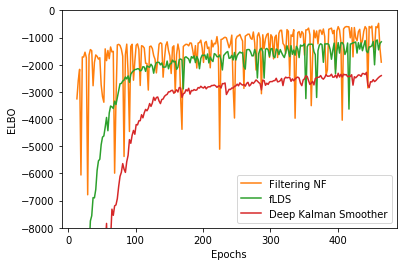

In [27]:
skip_ = 180

plot_elbo(l, skip=skip_, epoch=90, offset=1000, c='C1')
plot_elbo(l2, skip=skip_, epoch=90, offset=1000, c='C2')
plot_elbo(l3, skip=skip_, epoch=90, offset=1000, c='C3')

plt.ylim(-8000, 0)
plt.legend(['Filtering NF', 'fLDS', 'Deep Kalman Smoother'])
#plt.savefig("Lorenz.pdf")

# Compare the path reconstructions of different methods

In [26]:
#%matplotlib tk
%matplotlib inline

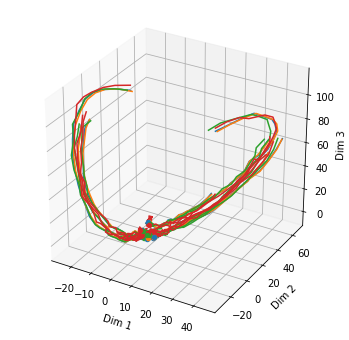

In [22]:
tplot.plot([0, 1, 2], PCA=False, data=TEST_DATA, c='C0')
tplot.plot([0, 1, 2], PCA=False, data=r.mean(axis=1), plt_ax=plt.gca(), c='C1')
tplot.plot([0, 1, 2], PCA=False, data=r2.mean(axis=1), plt_ax=plt.gca(), c='C2')
tplot.plot([0, 1, 2], PCA=False, data=r3.mean(axis=1), plt_ax=plt.gca(), c='C3')
plt.gcf().set_size_inches(6, 6)

In [94]:
real_ext = DATA[90:, TIME:]

i = 4

# methods, examples, mc_samples, ...
extras = np.zeros([3, 10, 10, LEAVE_OUT, DIM])

for i in range(10):
    with graph.as_default():
        ext_ = diag.get_extrapolations(init_points=c[i, :, -1:])
    extras[0, i, :] = ext_[1]

    with graph2.as_default():
        ext_ = diag2.get_extrapolations(init_points=c2[i, :, -1:])
    extras[1, i, :] = ext_[1]

    with graph3.as_default():
        ext_ = diag3.get_extrapolations(init_points=c3[i, :, -1:])
    extras[2, i, :] = ext_[1]

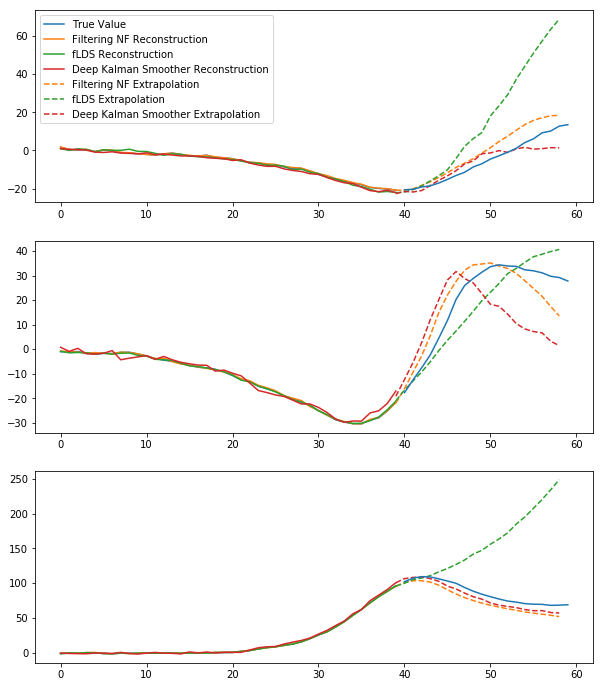

In [152]:
PLOT_K = DIM

fig, ax = plt.subplots(PLOT_K, 1)

i = 4

for dim in range(PLOT_K):
    ax[dim].plot(np.arange(TIME), TEST_DATA[i:i+1, :, dim].T,  c='C0')
    ax[dim].plot(np.arange(TIME), r.mean(axis=1)[i:i+1, :, dim].T, c='C1')
    ax[dim].plot(np.arange(TIME), r2.mean(axis=1)[i:i+1, :, dim].T, c='C2')
    ax[dim].plot(np.arange(TIME), r3.mean(axis=1)[i:i+1, :, dim].T, c='C3')
    t_ = TIME - 1
    ax[dim].plot(range(t_, t_ + LEAVE_OUT),
                 extras[0, i, :, :, dim].mean(0), '--', c='C1')
    ax[dim].plot(range(t_, t_ + LEAVE_OUT),
                 extras[1, i, :, :, dim].mean(0), '--', c='C2')
    ax[dim].plot(range(t_, t_ + LEAVE_OUT),
                 extras[2, i, :, :, dim].mean(0), '--', c='C3')
    t_ = TIME
    ax[dim].plot(range(t_, t_ + LEAVE_OUT), real_ext[i, :, dim], c='C0')

ax[0].legend(["True Value", "Filtering NF Reconstruction", "fLDS Reconstruction",
              "Deep Kalman Smoother Reconstruction",
              "Filtering NF Extrapolation", "fLDS Extrapolation", "Deep Kalman Smoother Extrapolation"])

fig.set_size_inches(10, 4 * PLOT_K)

#plt.savefig("lorenz_extrapolation_{}.pdf".format(i))

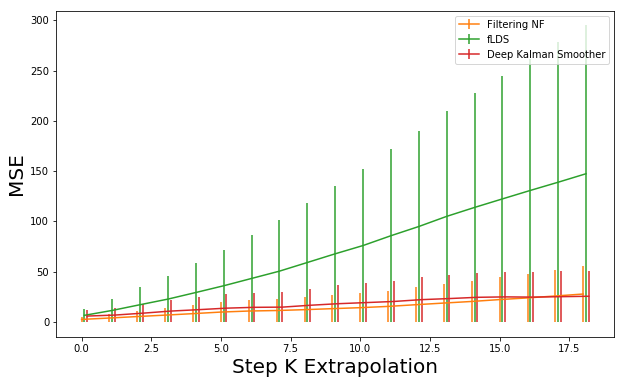

In [141]:
for i in range(3):
    d, dstd = k_step_extrapolation_error(
        real_ext[:, :-1 ,], extras[i, :, :, 1:])
    plt.errorbar(np.arange(19) + i * 0.1, d.T, dstd.T, c="C{}".format(i + 1))

plt.legend(["Filtering NF", "fLDS", "Deep Kalman Smoother"])
plt.xlabel("Step K Extrapolation", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.gcf().set_size_inches(10, 6)

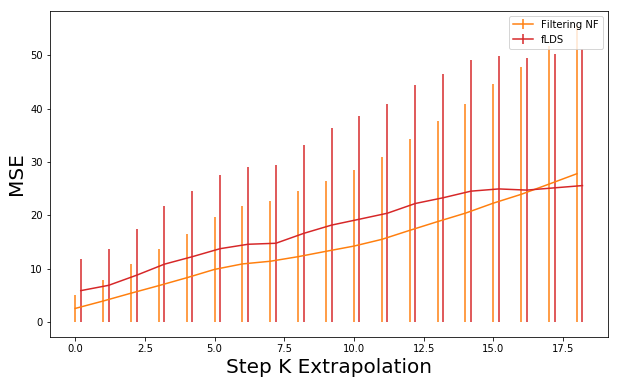

In [140]:
for i in [0, 2]:
    d, dstd = k_step_extrapolation_error(
        real_ext[:, :-1 ,], extras[i, :, :, 1:])
    plt.errorbar(np.arange(19) + i * 0.1, d.T, dstd.T, c="C{}".format(i + 1))

plt.legend(["Filtering NF", "fLDS", "Deep Kalman Smoother"])
plt.xlabel("Step K Extrapolation", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.gcf().set_size_inches(10, 6)